# PW 1 - Practical work on SAR imaging : introduction to SAR data and interferometric processing 
The aim of this PW is to get familiar with SAR data (high dynamic of the images, complex data with ampltidue and phase). After a first part on the visualization of such data and the understanding of the image content, the second part is dedicated to the processing of phase and interferometric data.

## 1. Analysis of a series of SAR images
In this part, we will have a look at a temporal series of 25 SAR images acquired [from 2015-10-06 to 2016-11-05](https://perso.telecom-paristech.fr/tupin/TPSAR/pilelely/PileLely_3072x1024RECALZ4.label), with a time delay of approximately 12 days.

By making use of these SAR images, we will see the main differences with respect to conventional natural images and develop some simple tools to visualize an image, interpret it and detect temporal changes.

In [1]:
!wget https://perso.telecom-paristech.fr/tupin/TPSAR/mvalab.py

import scipy
from scipy import signal
import scipy.signal
import scipy as spy
import scipy.fftpack
from scipy import ndimage
from scipy import special
from scipy import ndimage
import numpy as np
import math
import matplotlib.pyplot as plt
import mvalab as mvalab
from urllib.request import urlopen
import cmath
from google_drive_downloader import GoogleDriveDownloader as gdd


plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['figure.max_open_warning'] = 30

--2023-04-25 19:56:18--  https://perso.telecom-paristech.fr/tupin/TPSAR/mvalab.py
Resolving perso.telecom-paristech.fr (perso.telecom-paristech.fr)... 137.194.22.227, 2a04:8ec0:0:a::89c2:16e3
Connecting to perso.telecom-paristech.fr (perso.telecom-paristech.fr)|137.194.22.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68071 (66K) [text/x-python]
Saving to: ‘mvalab.py’

mvalab.py           100%[===================>]  66.48K  --.-KB/s    in 0.1s    

2023-04-25 19:56:19 (461 KB/s) - ‘mvalab.py’ saved [68071/68071]



In [2]:
# Download of the time series
webpage = 'https://perso.telecom-paristech.fr/tupin/TPSAR/pilelely/multitemp/'
imagename = 'lely_tuple_multitemp.IMA'
imaslc = mvalab.imz2mat(webpage+imagename) # complex image

time_series_amp = np.abs(imaslc[0]) # taking an array of shape [n_rows,n_columns,n_dates] in amplitude format

imz2mat : version janvier 2018.  Fichier à ouvrir : https://perso.telecom-paristech.fr/tupin/TPSAR/pilelely/multitemp/lely_tuple_multitemp.IMA
Nom compatible url
Nom compatible url
INFO - reading header/dim : https://perso.telecom-paristech.fr/tupin/TPSAR/pilelely/multitemp/lely_tuple_multitemp.dim
Multitemporal image 25 data
Fichiers PC
Image  complex float
lecture .dim OK -> largeur:512 hauteur:512 profondeur:25
Debug 2 4 512
4 512 <f


### Question 1.1: display a SAR image
SAR images have a long-tailed distribution, making its dynamic range to be wide. Plot the image with matplotlib. What do you see? 

It looks like an optical image with a low exposition and a low contrast. How can you improve the contrast of a SAR image, in order to have a more pleasant visualization?
Implement a function to plot a SAR image and comment the results obtained. 

A usual way to do this, is the saturate all the values above a certain threshold (often chosen as the mean + 3 times the standard deviation of the image) and do a linear stretching for the other values. 
Explain the effect of this processing and what you see in the resulting image. 

### Answer 1.1


The range of the image being too wide, we see only a few points with the highest intensity (points where there was a lot of reflection), and we miss a lot of information. 
By using a binary threshold of mean + 3*std, we make sure that we will be able to see the points with an average density, reducing consideratly the dynamic range of the image.

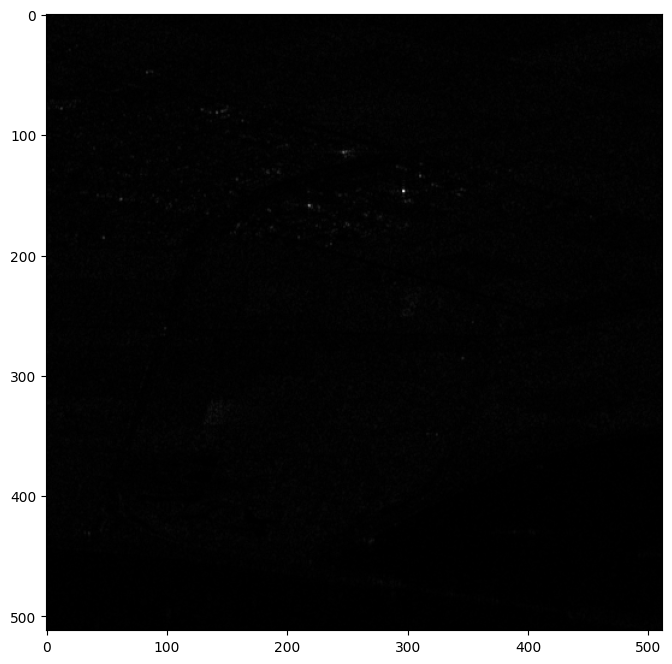

In [3]:
plt.figure()
plt.imshow(time_series_amp[:,:,0],cmap='gray')
plt.show()

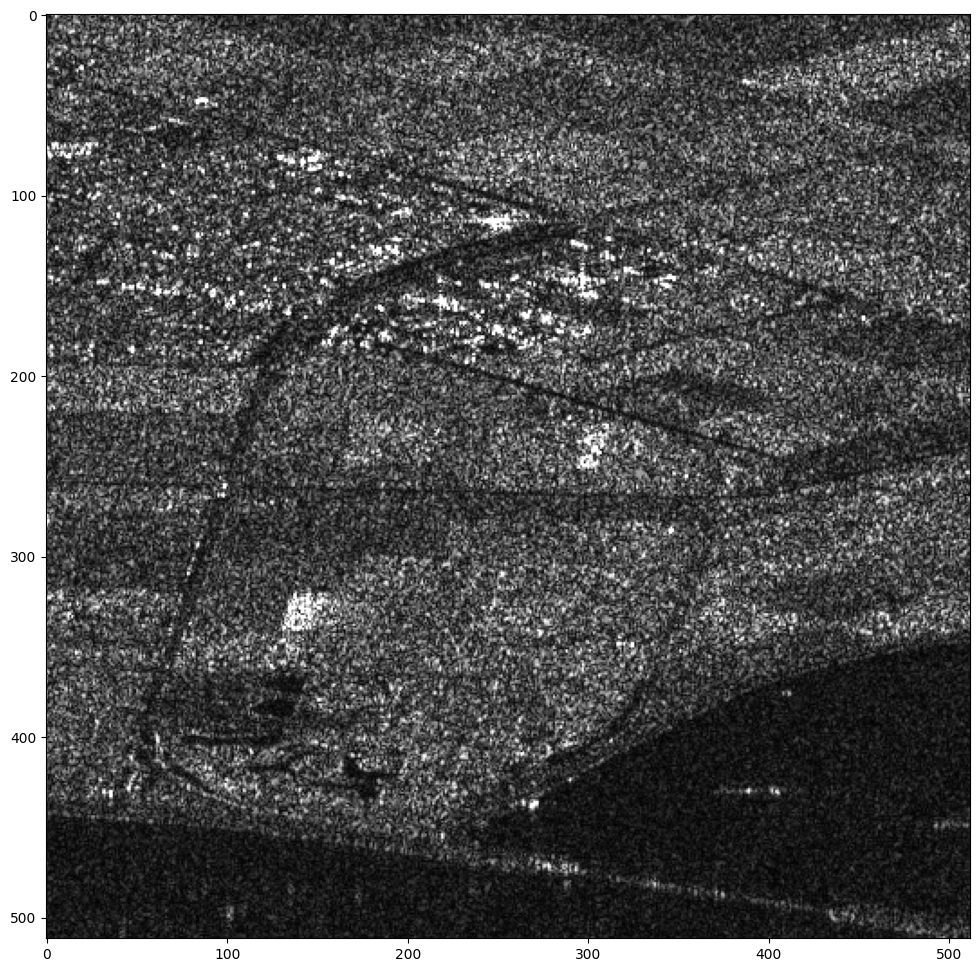

In [7]:
# implement the following function to plot a SAR image
# you can use a threshold as mean + 3 sigma
# and the np.clip function

def plot_sar(ima):
  plt.figure(figsize=(12,12))
  t = np.mean(ima) + 3 * np.std(ima) # choose the appropriate theshold
  thresholded_ima = np.clip(ima, 0, t)
  thresholded_ima = 255*thresholded_ima
  plt.imshow(thresholded_ima, cmap='gray') # display the saturated image
  plt.show()

plot_sar(time_series_amp[:,:,0])

### Question 1.2: Image orientation
Is the image in the correct geographic orientation? 
Apply the proper flipping if necessary.

To see the corresponding optical image and find the correct flipping, you can have a look on Google Maps at [this location](https://goo.gl/maps/LQcd3Uz9U7qCoRrH6).

### Answer 1.2
The image is flipped along the vertical axis, so we have to flip it back.

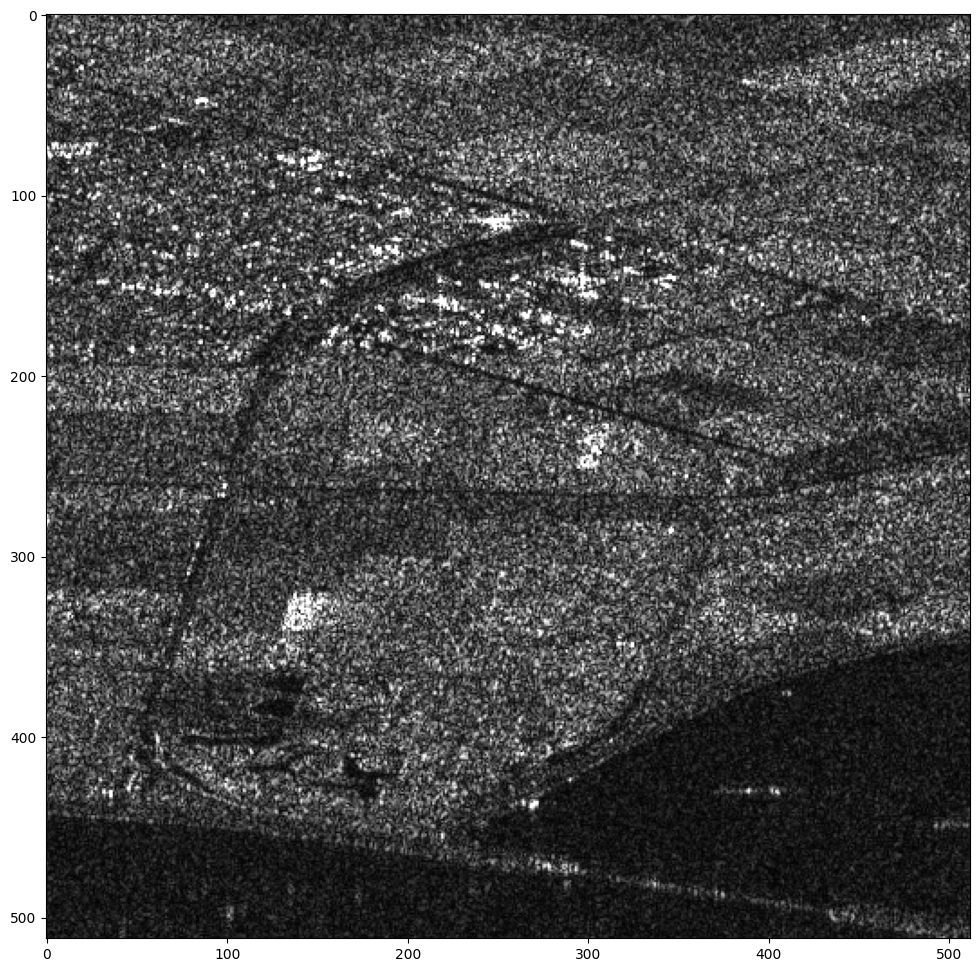

In [8]:
plot_sar(time_series_amp[:,:,0])

In [11]:
time_series_flipped = np.copy(time_series_amp)
time_series_flipped = np.flip(time_series_flipped, axis=1) # apply flipping if necessary using np.flip

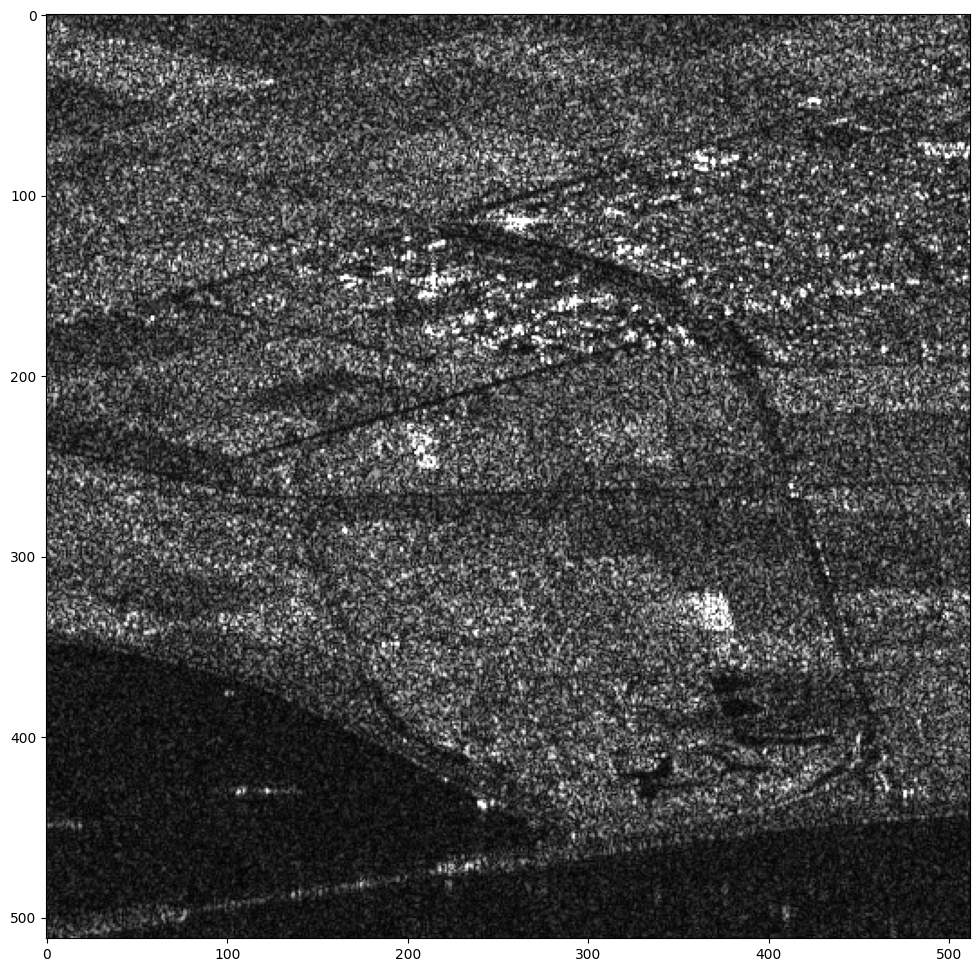

In [12]:
plot_sar(time_series_flipped[:,:,0])

### Question 1.3: Interpretation of a SAR image
The image contains 
- an urban area, 
- agricultural fields, 
- water, 
- moving objects (ships), 
- a bridge 

Explain the appearence of these objects in the SAR image.

### Answer 1.3
- urban area: We can distinguish the shape of buildings because their sharp edges allow for reflection towards the sensor.
- agricultural fields: The fiels appear with less intensity and less defined contours, because reflection on the soil and/or the crops is more variable than the one on buildings.
- water: THe water appears pitch black, because almost no signal gets back to the sensor.  
- moving objects (ships): They appear as bright as the urban area, but shifted on the sea.
- the bridge: The bridge also appears as bright as the urban area, very distinguishable because it is over the water.


### Question 1.4: Multitemporal analysis and change detection
To detect changes occurring between three dates, images can be displayed in a false colour representation, each date being one channel of a RGB image. Implement the function ```plot_changes```.

Then, choose three dates from the multitemporal stack (indexes from 0 to 24). From the false colour representation, can you tell when a particular change has occurred? Explain how you can interpret it.

### Answer 1.4
We see most changes on the fields. That could be because between the tree dates, the crops grew and/or were cut down, changing the reflection properties of the fiels. We notice that there is no color on the urban area, because the buildings did not move an inch between the three dates. We could also that we some small dots of color on the water, that may represent the fact that ships have moved between the tree dates.

In [13]:
def plot_changes(im1,im2,im3):
    threshold = np.mean([np.mean(im1) + 3 * np.std(im1), np.mean(im2) + 3 * np.std(im2), np.mean(im3) + 3 * np.std(im3)]) # select a unique threshold for the three images
    # apply thresholding and shrinking of each image between [0;1] for RGB data
    im1 = np.clip(im1,0,threshold)
    im1 = im1/threshold
    im2 = np.clip(im2,0,threshold)
    im2 = im2/threshold
    im3 = np.clip(im3,0,threshold)
    im3 = im3/threshold
    image = np.stack([im1,im2,im3],axis=2) # create a false RGB image by stacking the three dates
    plt.figure(figsize=(12,12))
    plt.imshow(image)
    plt.show()

In [14]:
# choose three dates
idx1 = 1 
idx2 = 10 
idx3 = 15
im1 = time_series_flipped[:,:,idx1]
im2 = time_series_flipped[:,:,idx2]
im3 = time_series_flipped[:,:,idx3]

plot_sar(im1)
plot_sar(im2)
plot_sar(im3)
plot_changes(im1,im2,im3)

Output hidden; open in https://colab.research.google.com to view.

### Question 1.5: Create an image with isotropic pixels
The image pixels have the following size: $13.86[m]\times 2.3[m]$ in range $\times$ azimuth (approximately, pixel height is 5 times greater than pixel length). How can you create an image with approximately squared pixels?

### Answer 1.5
We can resample the image to get approximately squared pixels.

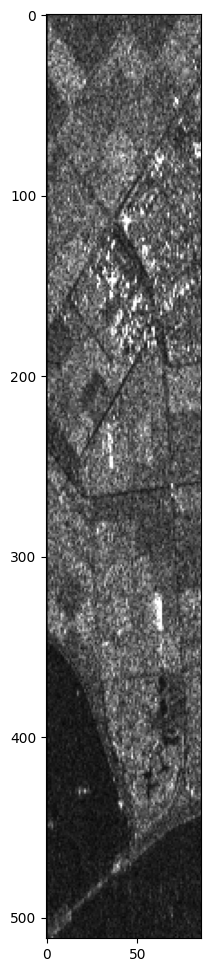

In [15]:
ima_tmp = time_series_flipped[:,:,0]

mask = np.array([[0.2,0.2,0.2,0.2,0.2]]) 
ima_filtered = scipy.signal.convolve2d(ima_tmp,mask) # filter the image with the appropriate mask
ima_squared_pixels = ima_filtered[:,::int(13.86/2.3)] # resample the filtered image
plot_sar(ima_squared_pixels)

## 2. Analysis of TerraSAR-X images acquired over the Paris area
In this part we will use an image of TerraSAR-X sensor (metric resolution) of Paris. 
This is a temporal stack, you can choose the date you want. 
(The questions are similar to the previous ones and will not be done during the PW but later as personal work).

In [16]:
# 21 images from TerraSAR-X between 2009-01-24 and 2010-11-26
webpage='https://perso.telecom-paristech.fr/tupin/TPSAR/paris/'
image='PileiEiffeljavelRECALZ4RECSP.IMA'
im_slc_tsx_paris_liste=mvalab.imz2mat(webpage+image);
im_slc_tsx_paris = im_slc_tsx_paris_liste[0][:,:,0]
plt.rcParams['figure.figsize'] = [18, 18]
mvalab.visusar(np.abs(im_slc_tsx_paris))

Output hidden; open in https://colab.research.google.com to view.

### Question 2.1: interpretation
Check that you recognize the main buildings on this image. 
What is the position of the track of the sensor relatively to this image ?

Explain the appearence of the following buildings in the amplitude image : Eiffel Tower, Maison de la radio, Pont de Bir-Hakeim (you can use a [satellite optic image on googlemaps](https://www.google.com/maps/place/Eiffel+Tower/@48.851143,2.2797819,447m/data=!3m1!1e3!4m5!3m4!1s0x47e66e2964e34e2d:0x8ddca9ee380ef7e0!8m2!3d48.8583701!4d2.2944813) to help you).



### Answer 2.1
The sensor is on the right (because the Eiffel Tower appears projected on the left).

The difference of amplitude between the Eiffel Tower, Maison de la Radio and Pont de Bir-Hakeim is due to the difference of their architecture (Eiffel Tower appears the brightest because it is made out of metal and has a lot of sharp edges). Their position in the image depends of their position relative to the sensor.

### Question 2.2: change detection
Identify and explain the appearence of some changing objects on Paris.

### Answer 2.2
Changes on the banks of Seine river are barges that moved/changed spot.
There aren't many changes on the buildings.

In [17]:
idx1 = 1 
idx2 = 10 
idx3 = 15
im1 = np.abs(im_slc_tsx_paris_liste[0][:,:,idx1])
im2 = np.abs(im_slc_tsx_paris_liste[0][:,:,idx2])
im3 = np.abs(im_slc_tsx_paris_liste[0][:,:,idx3])

plot_sar(im1)
plot_sar(im2)
plot_sar(im3)
plot_changes(im1,im2,im3)

Output hidden; open in https://colab.research.google.com to view.

## 3. SAR interferometry
In this part, the objective is to see the content of the phase of a SAR image and to do a simple processing chain to obtain an interferogram with topographic fringes. 
You will be able to have a look to the optical image [on this link](https://g.page/ParcoEtna?share)

In [18]:
!wget https://perso.telecom-paristech.fr/tupin/TPSAR/interfero/Master.mat
!wget https://perso.telecom-paristech.fr/tupin/TPSAR/interfero/Slave.mat
imageM='./Master.mat'
imageS='./Slave.mat'
imamaitre=mvalab.matlab2imz(imageM,'Master')
imaslave=mvalab.matlab2imz(imageS,'Slave')

imamaitre = imamaitre[0][1000:3000,:]
imaslave = imaslave[0][1000:3000,:]
ncolonnes=imamaitre.shape[1]
nlignes=imamaitre.shape[0]

#%%
plt.rcParams['figure.figsize'] = [18, 18]
mvalab.visusar(imamaitre)
mvalab.visusar(imaslave)

Output hidden; open in https://colab.research.google.com to view.

In [19]:
# display the phase of one image
#mvalab.visuinterfero uses an adapted lut to see the phase of an image
mvalab.visuinterfero(np.angle(imamaitre)+math.pi,0)


Output hidden; open in https://colab.research.google.com to view.

### Question 3.1
Do you recognize the area in the amplitude images ? Give a short interpretation. Visualize the phase of an image. Do you see any useful information?

### Answer 3.1
I can't distinguish any useful information in the phase image.

### Question 3.2
Compute the interferogram by computing $z_1.z_2^*$ and display the phase. Do you see any structured pattern ?

In [ ]:
raw_interf = np.angle(imamaitre * np.conj(imaslave)) # compute z1.z2*
plt.rcParams['figure.figsize'] = [18, 18]
mvalab.visuinterfero(raw_interf) # diplay the phase 

Output hidden; open in https://colab.research.google.com to view.

### Answer 3.2
This time, we can see vertical lines appearing. They seem to follow the same pattern as the original radar image.

### Question 3.3: Registration of the two images
To compute an interferogram, the following steps have to be applied :
- registration of the two images (only a translation is searched)
- suppression of the vertical fringe pattern 
- filtering to improve the phase information.

Using the knowledge acquired on previous courses, propose a method and apply it to do the registration between the two images. Complete the code below.

In [20]:
# propose a method to extract the shift along the two axes
# to compute the correlation efficiently you can use the FFT 

# using the multiplication in the Fourier domain, compute the FFT of the correlation and then the correlation by inverse FFT
imacorfft = np.conj(np.fft.fft2(np.abs(imamaitre))) * np.fft.fft2(np.abs(imaslave))# to be completed
imacor= np.fft.ifft2(imacorfft) # to be completed

#visualize the correlation image (maximum gives the translation value)
mvalab.visusar(imacor)
ishift = np.unravel_index(np.argmax(imacor),imacor.shape) # you can use np.argmax and np.unravel_index
print(ishift)

# compute the shift on the two axis
imaslaveroll=np.roll(imaslave, -ishift[0], axis=0)
imaslaveroll=np.roll(imaslaveroll, -ishift[1], axis=1)

# compute the interferogram and plot the interferometric phase
interfero= imamaitre * np.conj(imaslaveroll) # to be completed
plt.rcParams['figure.figsize'] = [18, 18]
mvalab.visuinterfero(np.angle(interfero)+math.pi,0)

Output hidden; open in https://colab.research.google.com to view.

### Question 3.4
What is the shift between the two images ? Which pattern do you see in the resulting fringes when computing the interferogram after the registration ? 

### Answer 3.4
The shift is (2,0), meaning there is an horizontal shift of 2 pixels. We still see the vertical lines as before.

### Question 3.5: Suppression of the orbital fringes 
To obtain the useful information about the topography the so-called orbital fringes have to be suppressed. It can be done by using the sensor parameters but in this practical work we propose to use a signal processing method. 
How can you detect a pure sinusoid in a signal ? (it is the case of the pattern we would like to suppress in the horizontal direction). Compute the frequency of this pattern and use it to suppress it in the registered secondary image. 

Which frequency did you obtain ? Is it the same for all the considered lines ? What do you see in the resulting interferogram after correction ? 

Chosen frequency : 87.65


/usr/local/lib/python3.9/dist-packages/numpy/ma/core.py:3377: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/usr/local/lib/python3.9/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


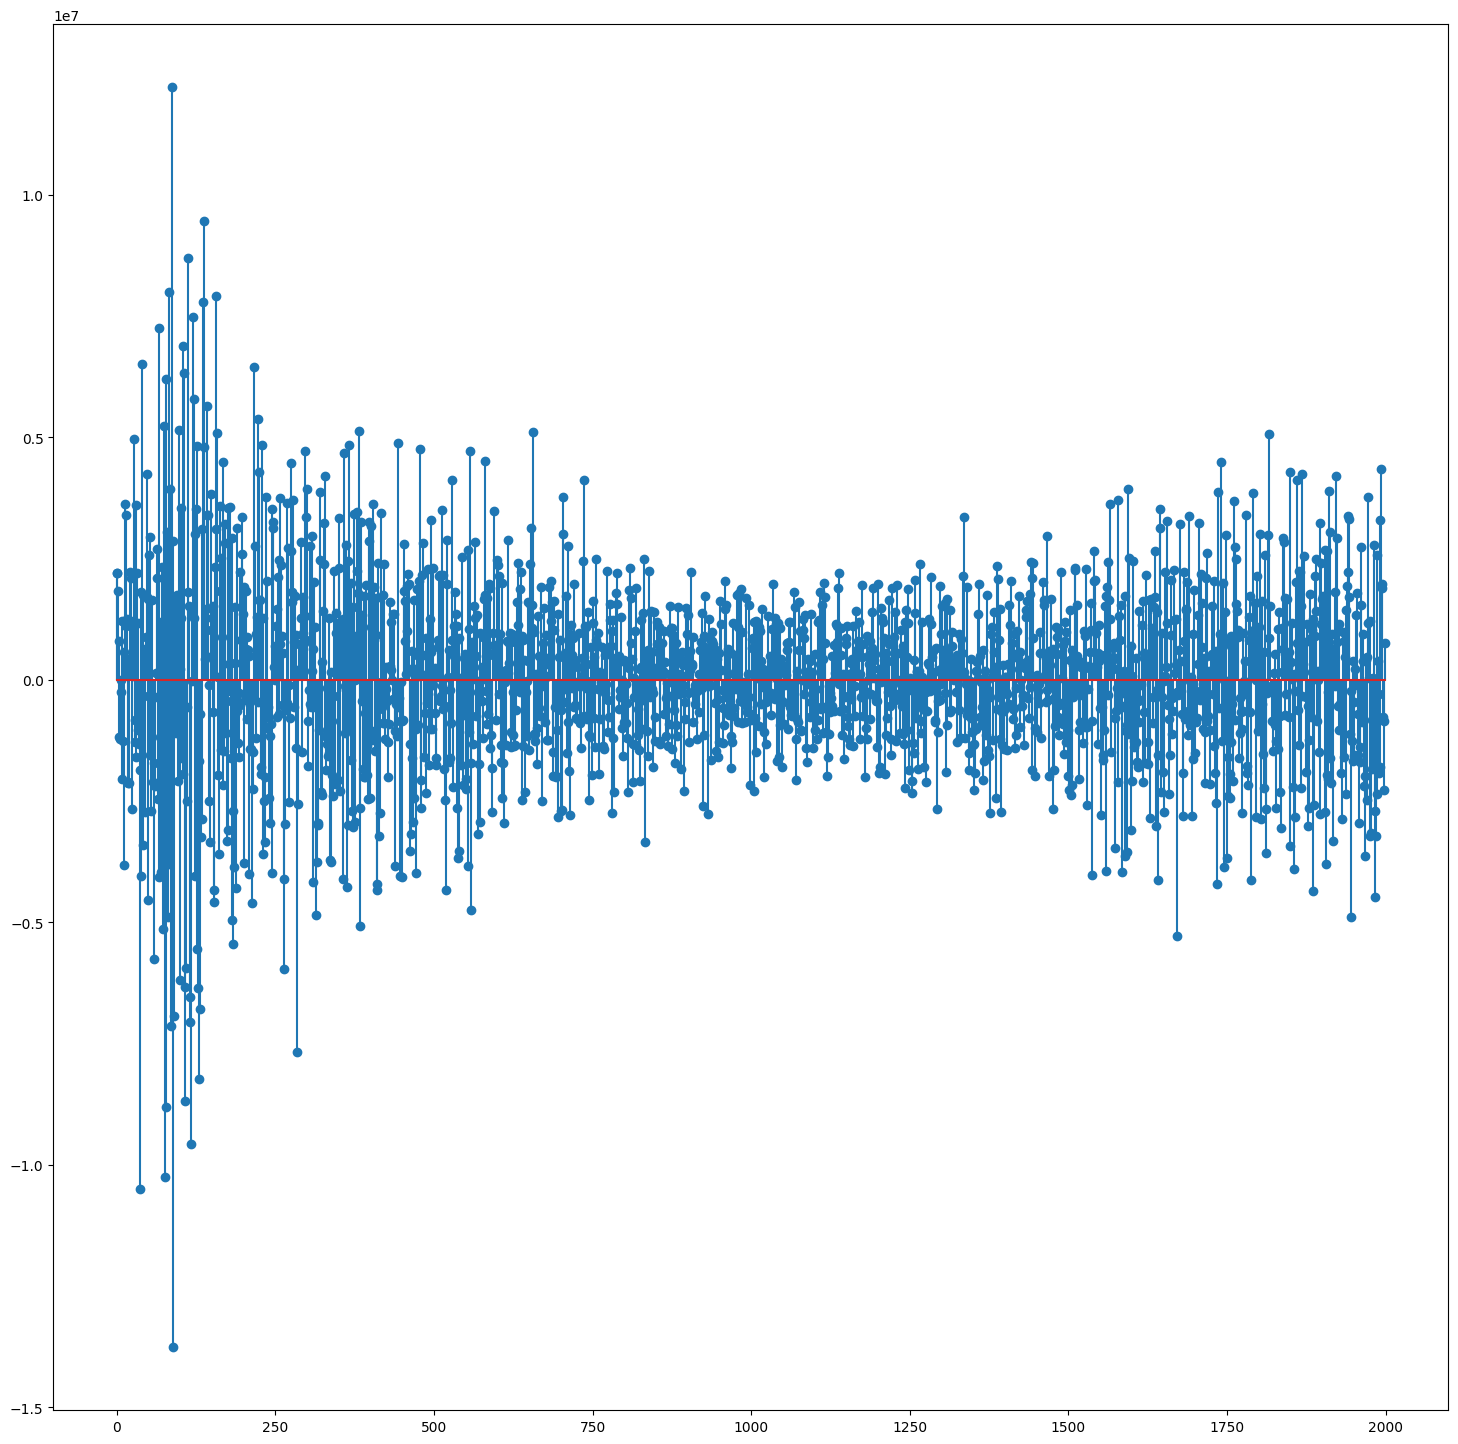

In [35]:
# compute the main frequency of the pattern by choosing a line in the image and using the FFT
freq_arr = []
for i in range(20):
  fftfringe = np.fft.fft(interfero[i,:]) # to be completed
  freq = np.unravel_index(np.argmax(np.abs(fftfringe)), fftfringe.shape)
  freq_arr.append(freq)

print("Chosen frequency : {}".format(np.mean(freq_arr)))

fftfringe = np.fft.fft(interfero[0,:]) # to be completed
plt.figure()
plt.stem(fftfringe)
plt.show()

### Answer 3.5a 
We get the frequency 87.65 (most of times the main frequency was either 87 or 88)

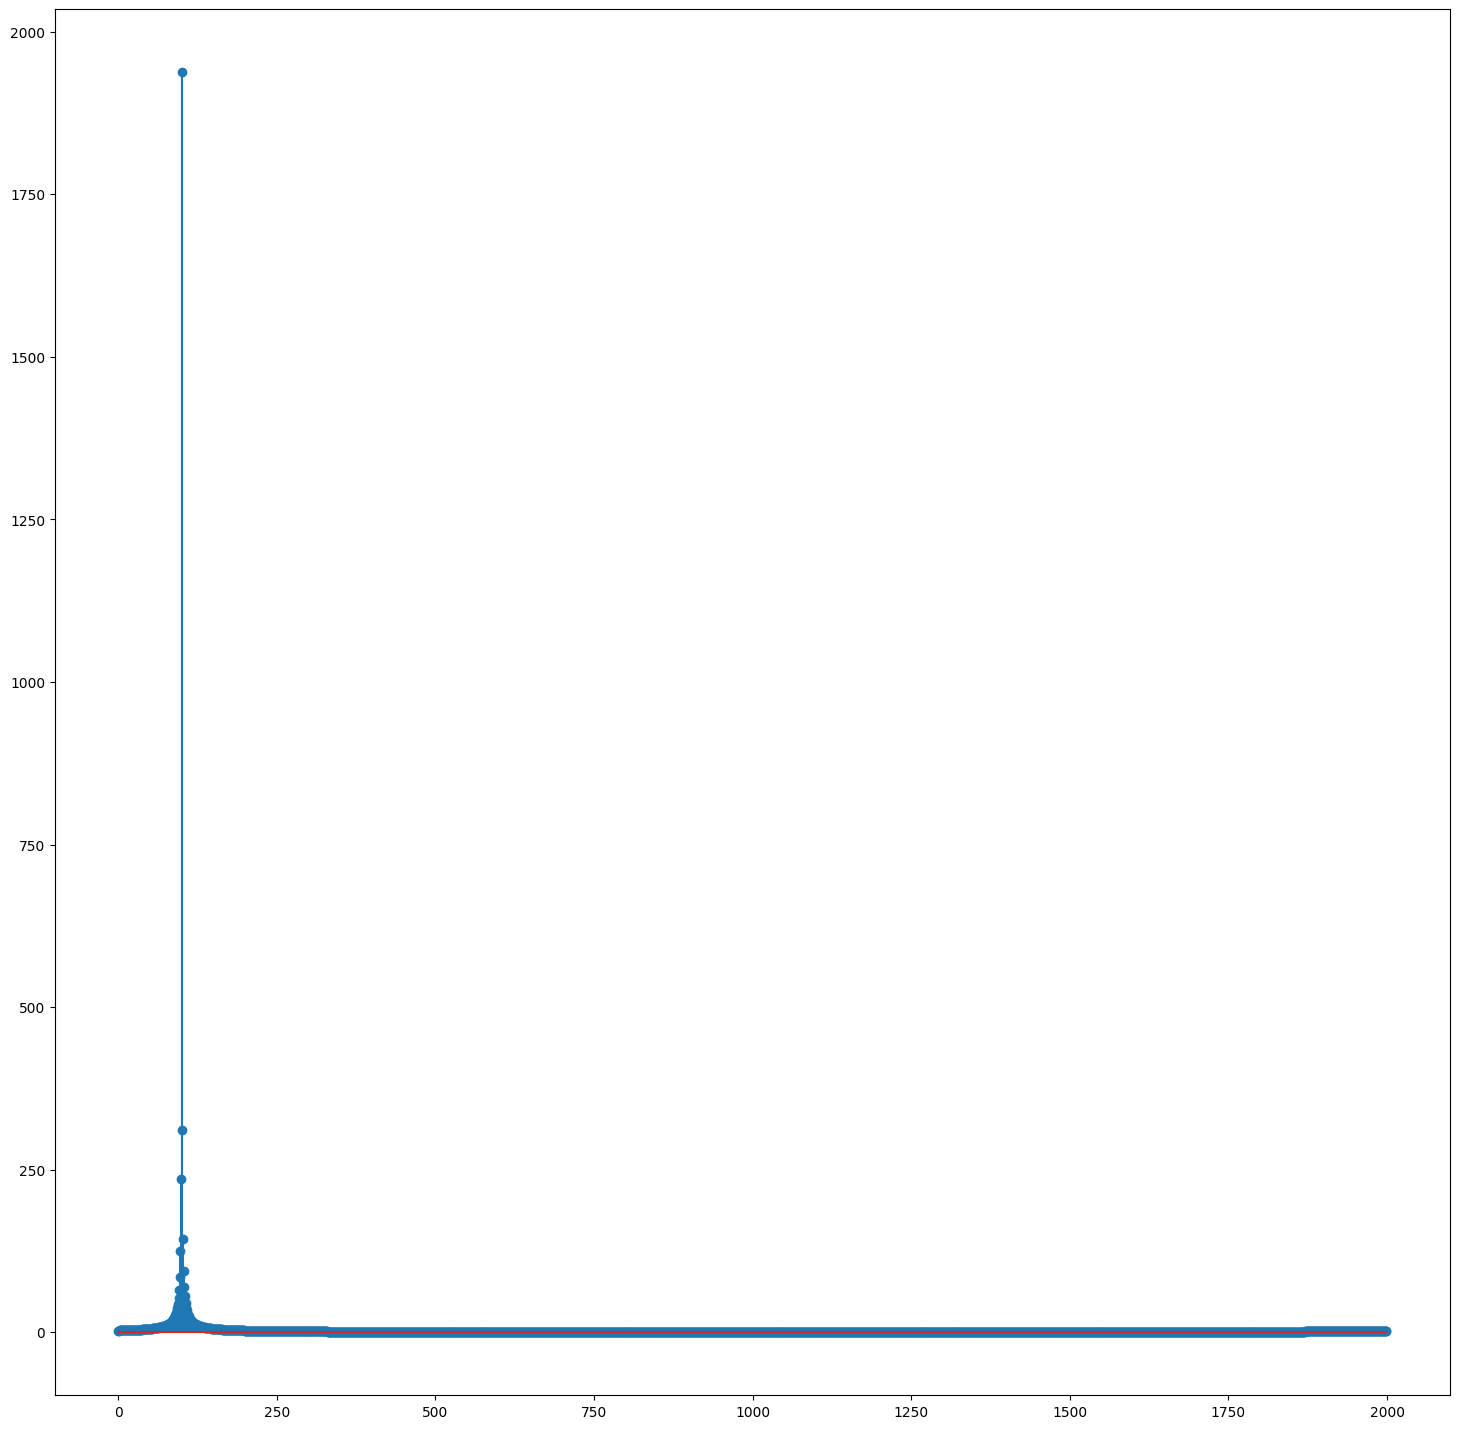

In [36]:
N = interfero.shape[1]
n = np.arange(0,N)
onde = np.exp(-1j*n*87.65)  # create a pure wave using the previously computed frequency freq 
fonde = np.abs(np.fft.fft(onde))
plt.figure()
plt.stem(fonde)
plt.show()

In [37]:
# suppress the pattern by multiplying the interferogram by the conjugate of the pure wave
interferofine= np.multiply(interfero,np.conj(onde))

mvalab.visuinterfero(np.angle(interferofine)+math.pi,0)

Output hidden; open in https://colab.research.google.com to view.

### Answer 3.5b 
In the resulting interferogram, we can clearly see the crater of Mount Etna.

### Question 3.6: interferogram filtering
To improve the quality of the interferogram, some filtering can be applied to reduce the phase noise. Propose a suitable kernel by filling the code below.

How does the filtered interferogram look like?

### Answer 3.6
We use an averaging mask, to smooth the image i.e. reduce to a certain extent the noise.

In [40]:
def interferogramme( tabvignette, tabvignette2, *therest) :
    """
    Computation of the complex interferogram between two images of the
    same size.
    By default, window size is set as 3x3 (dimx, dimy).
    It outputs a complex image, whose modulus is the coherence and whose phase 
    is the interferometric phase.
    """
    
    dimx=3
    dimy=3
    
    if(len(therest)==1):        
        dimx=therest[0]
        dimy=dimx
        
    if(len(therest)==2):       
        dimx=therest[0]
        dimy=therest[1]
    
    nlig=np.size(tabvignette,0)
    ncol=np.size(tabvignette,1)
    
    if nlig != np.size(tabvignette2,0)  :
        print(u'les deux images doivent avoir la même taille (%d  et %d)'%(nlig, np.size(tabvignette2,0)))
        return 0
    
    if ncol != np.size(tabvignette2,1)  :
        print(u'les deux images doivent avoir la même taille')
        return 0
    
    interf= np.multiply(tabvignette, np.conj(tabvignette2))

    # part to be completed to compute a multi-look interfergram by averaging on a local window
    
    
    mask = np.ones((2,2))/4 # to be completed
    interfiltr = signal.convolve2d(interf,mask,mode='same')
    
    den1 = np.sqrt(signal.convolve2d(np.square(np.abs(tabvignette)),mask,mode='same'))
    den2 = np.sqrt(signal.convolve2d(np.square(np.abs(tabvignette2)),mask,mode='same'))
 
    return interfiltr/(den1*den2+1e-12)

In [41]:
imaslavefine= np.multiply(imaslaveroll,onde)
filtered_interferogram = interferogramme(imamaitre,imaslavefine)
mvalab.visusar(np.abs(filtered_interferogram))
mvalab.visuinterfero(np.angle(filtered_interferogram),0)

Output hidden; open in https://colab.research.google.com to view.

### Question 3.7
Can you apply the convolution directly on the interferometric phase image ? 
What would happen in that case?